In [132]:
import pandas as pd
import numpy as np
import random
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, KFold, GridSearchCV)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, f1_score)
from IPython.display import SVG
from graphviz import Source
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from imutils import paths
import os
import cv2
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz

In [83]:
url = "https://github.com/10sajan10/CS6830_Project7/raw/main/sateliteimage.zip"

response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall()
        print(f"Files extracted")

Download successful!
Files extracted


In [84]:
def extract_color_stats(image):

    B, G, R = cv2.split(image)

    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    std_R, std_G, std_B = np.std(R), np.std(G), np.std(B)

    features = [mean_R, mean_G, mean_B, std_R, std_G, std_B]

    return features

In [85]:
imagePaths = paths.list_images(r'sateliteimage/')
data = []
labels_str = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    features = extract_color_stats(image)
    data.append(features)

    # extract the class label from the file path and update the labels list
    label = imagePath.split(os.path.sep)[-2].split("/")[1]
    labels_str.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels_str)

In [86]:
df = pd.DataFrame(data, columns=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'])
df['label'] = labels_str

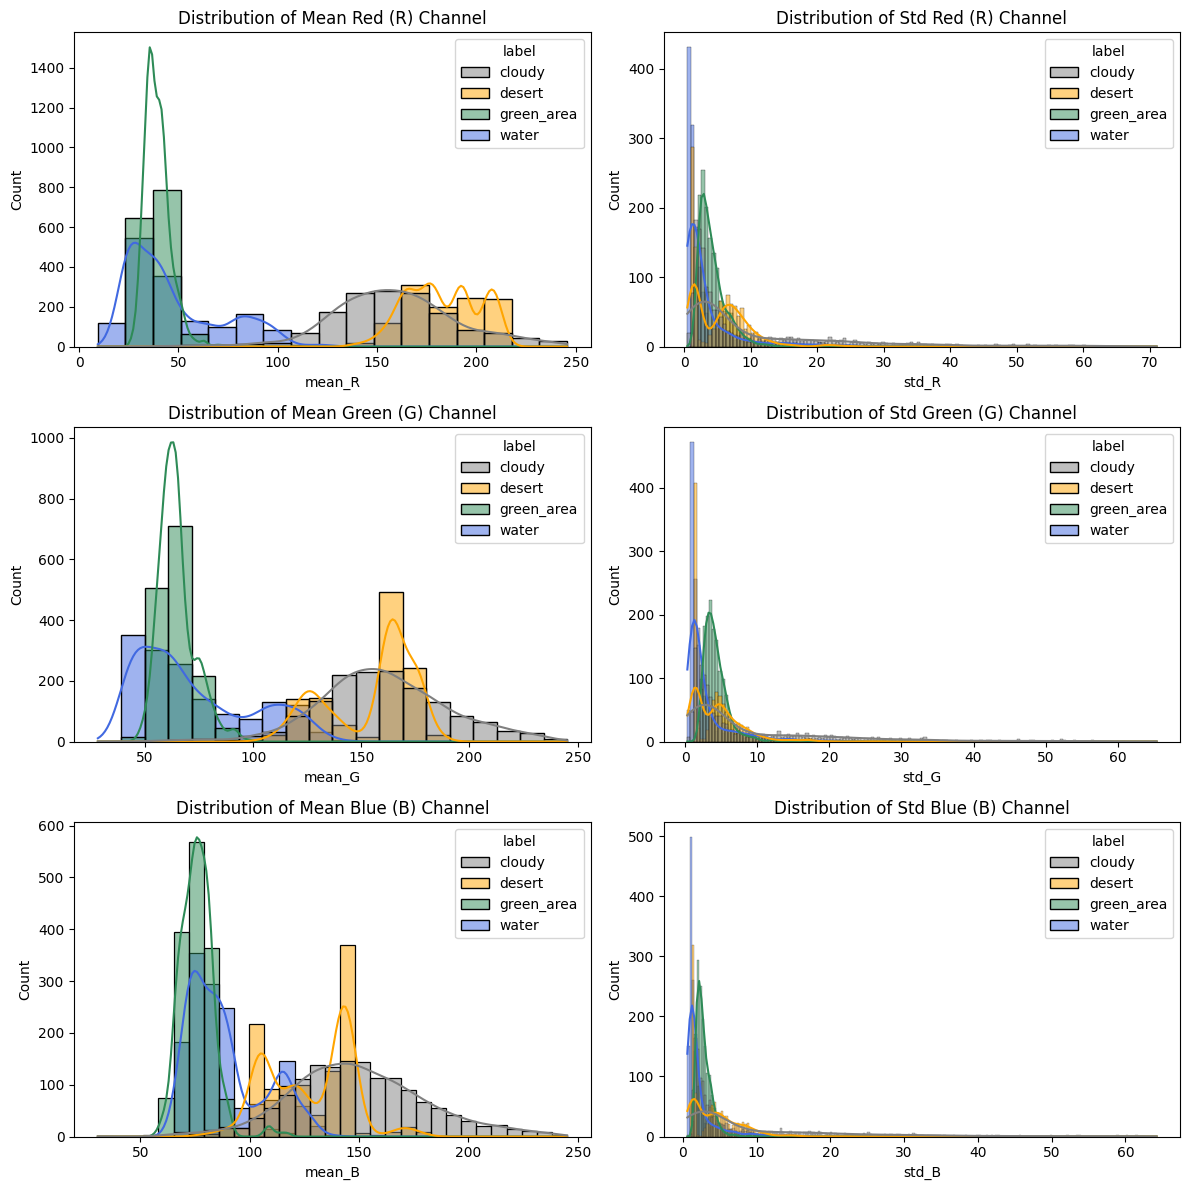

In [87]:
plt.figure(figsize=(12, 12))
color_mapping = {
    'cloudy': 'gray',
    'water': 'royalblue',
    'green_area': 'seagreen',
    'desert': 'orange'
}
# Plot for mean(R)
plt.subplot(3, 2, 1)
sns.histplot(data=df, x='mean_R', hue='label', palette=color_mapping, kde=True)
plt.title('Distribution of Mean Red (R) Channel')

# Plot for std(R)
plt.subplot(3, 2, 2)
sns.histplot(data=df, x='std_R', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Std Red (R) Channel')

# Plot for mean(G)
plt.subplot(3, 2, 3)
sns.histplot(data=df, x='mean_G', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Mean Green (G) Channel')

# Plot for std(G)
plt.subplot(3, 2, 4)
sns.histplot(data=df, x='std_G', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Std Green (G) Channel')

# Plot for mean(B)
plt.subplot(3, 2, 5)
sns.histplot(data=df, x='mean_B', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Mean Blue (B) Channel')

# Plot for std(B)
plt.subplot(3, 2, 6)
sns.histplot(data=df, x='std_B', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Std Blue (B) Channel')

plt.tight_layout()
plt.show()

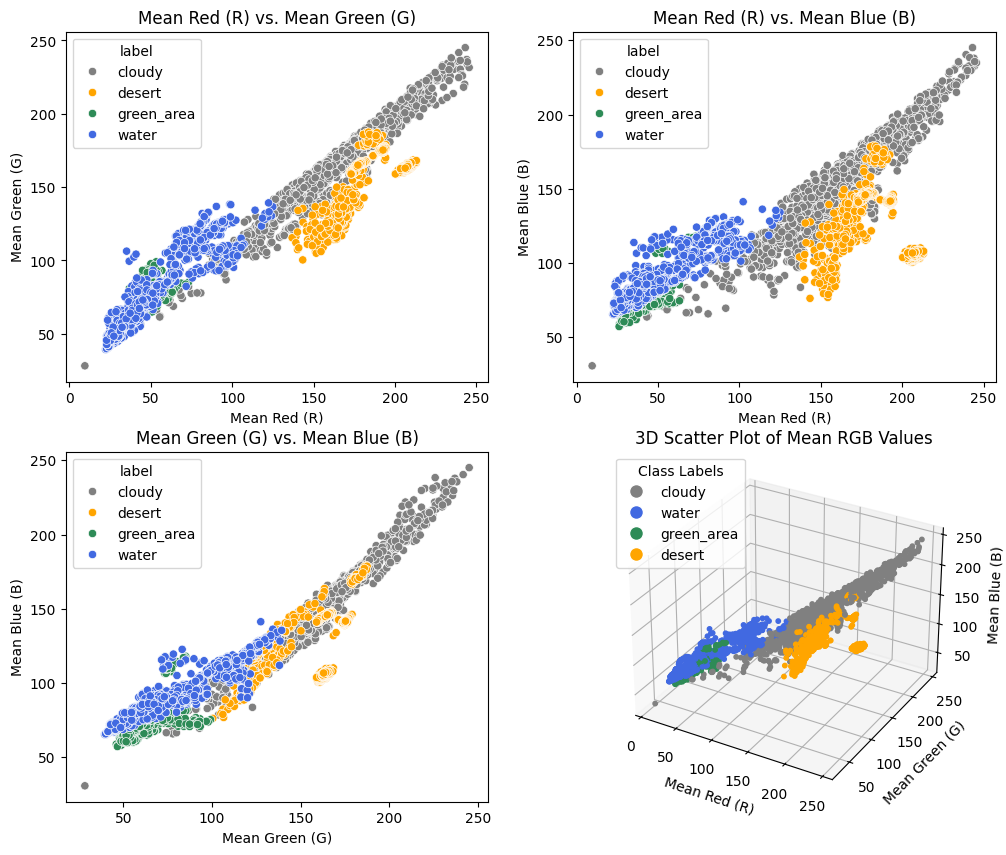

In [88]:
plt.figure(figsize=(12, 10))
color_mapping = {
    'cloudy': 'gray',
    'water': 'royalblue',
    'green_area': 'seagreen',
    'desert': 'orange'
}
df['color'] = df['label'].map(color_mapping)

# Plot for mean_R vs mean_G
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='mean_R', y='mean_G', hue='label', palette=color_mapping)
plt.title('Mean Red (R) vs. Mean Green (G)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Green (G)')

# Plot for mean_R vs mean_B
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='mean_R', y='mean_B', hue='label', palette=color_mapping)
plt.title('Mean Red (R) vs. Mean Blue (B)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Blue (B)')

# Plot for mean_G vs mean_B
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='mean_G', y='mean_B', hue='label', palette=color_mapping)
plt.title('Mean Green (G) vs. Mean Blue (B)')
plt.xlabel('Mean Green (G)')
plt.ylabel('Mean Blue (B)')


ax = plt.subplot(2, 2, 4, projection='3d')  # Set the 3D projection here

# Scatter plot with specified colors
ax.scatter(df['mean_R'], df['mean_G'], df['mean_B'], 
           color=df['color'],  # Use the color from the mapping
           s=10,  # Size of points
           alpha=1)  # Transparency

# Labels
ax.set_xlabel('Mean Red (R)')
ax.set_ylabel('Mean Green (G)')
ax.set_zlabel('Mean Blue (B)')
ax.set_title('3D Scatter Plot of Mean RGB Values')

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10) 
           for label in color_mapping]
ax.legend(handles, color_mapping.keys(), title="Class Labels")


In [89]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [90]:
treeclf = DecisionTreeClassifier(max_depth=4,)
treeclf.fit(trainX, trainY)

DecisionTreeClassifier(max_depth=4)

In [91]:
predictions = treeclf.predict(testX)

Confusion Matrix of Decision Tree Classifier:
[[286  27   6   9]
 [ 10 217   0   0]
 [  0   0 246  38]
 [  2   0  33 253]]


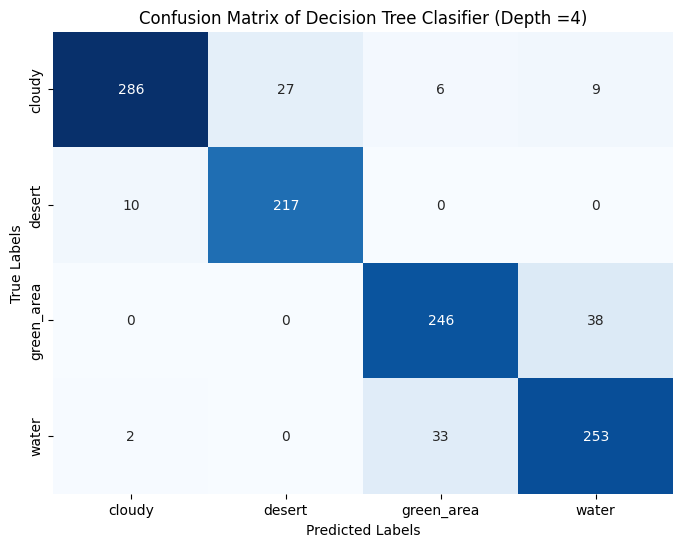

In [92]:
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Decision Tree Classifier:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Decision Tree Clasifier (Depth =4)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [93]:
print(f'Accuracy: {accuracy_score(testY, predictions):.2f}, '
      f'Recall: {recall_score(testY, predictions, average="weighted"):.2f}, '
      f'Precision: {precision_score(testY, predictions, average="weighted"):.2f}, '
      f'F1 Score: {f1_score(testY, predictions, average="weighted"):.2f}')


Accuracy: 0.89, Recall: 0.89, Precision: 0.89, F1 Score: 0.89


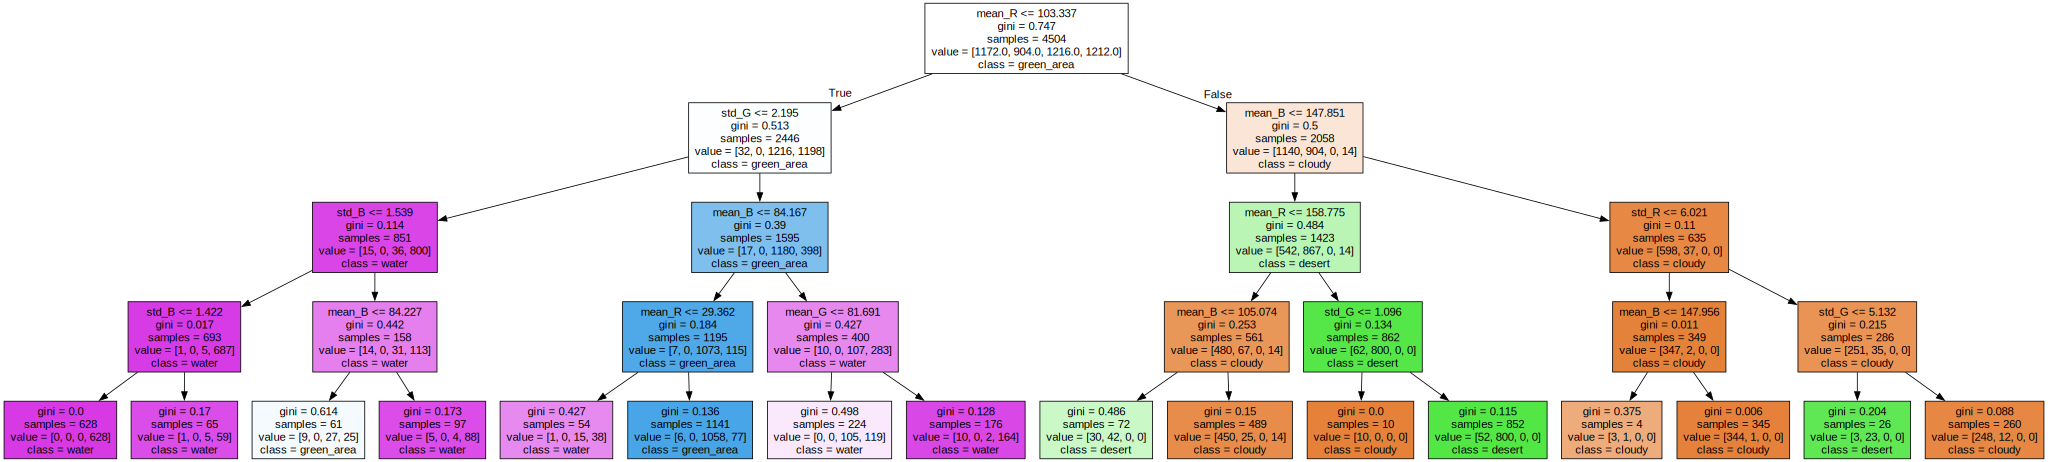

In [94]:
from sklearn import tree
graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'],
                                    class_names=le.classes_, filled = True))
svg = SVG(graph.pipe(format='svg'))
display(svg)

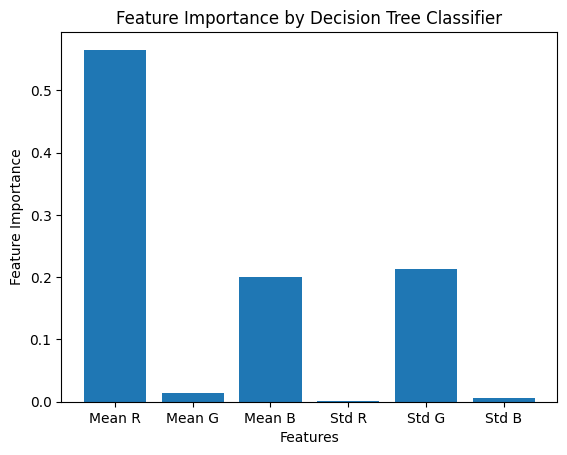

In [95]:
x_labels = ["Mean R", "Mean G", "Mean B", "Std R", "Std G", "Std B"]
plt.bar(height=treeclf.feature_importances_, x=range(len(x_labels)))
plt.xticks(ticks=range(len(x_labels)), labels=x_labels)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Feature Importance by Decision Tree Classifier")
plt.show()

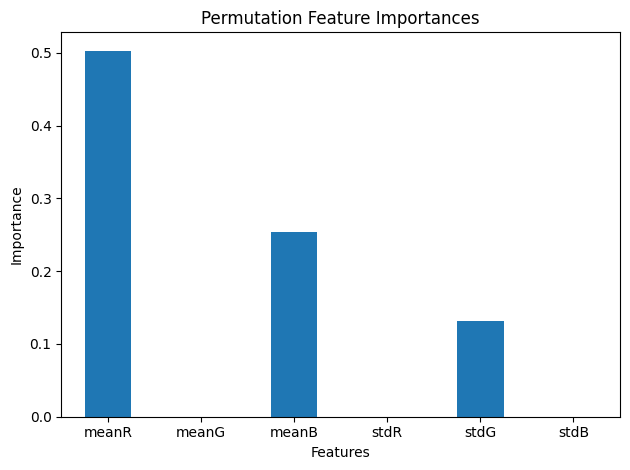

In [96]:
importances_mean = result['importances_mean']  # Replace with your actual result array
df_importances = pd.DataFrame(importances_mean, columns=["Importance"])
labels = ['meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB']
df_importances.plot(kind='bar', legend=False)
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.title('Permutation Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

Confusion Matrix of Logistic Regression:
[[294  19   6   9]
 [ 28 199   0   0]
 [  0   0 254  30]
 [  2   0  33 253]]


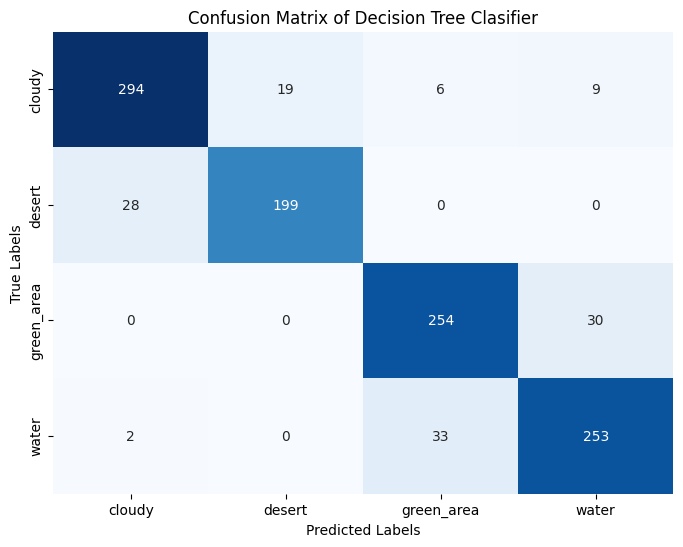

In [103]:
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(trainX, trainY)
predictions = treeclf.predict(testX)
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Decision Tree Clasifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

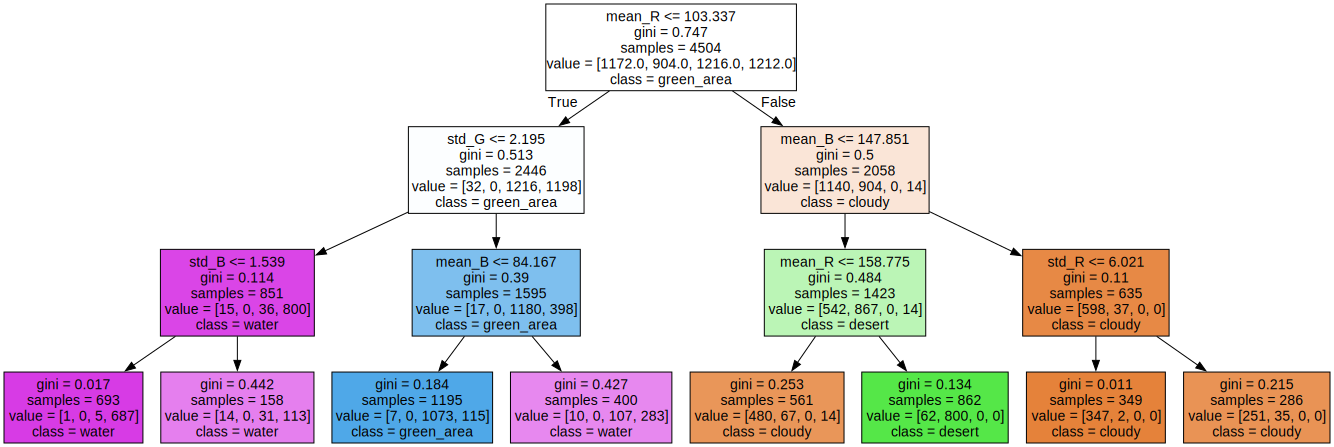

In [104]:
from sklearn import tree
graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'],
                                    class_names=le.classes_, filled = True))
svg = SVG(graph.pipe(format='svg'))
display(svg)

In [105]:
print(f'Accuracy: {accuracy_score(testY, predictions):.2f}, '
      f'Recall: {recall_score(testY, predictions, average="weighted"):.2f}, '
      f'Precision: {precision_score(testY, predictions, average="weighted"):.2f}, '
      f'F1 Score: {f1_score(testY, predictions, average="weighted"):.2f}')

Accuracy: 0.89, Recall: 0.89, Precision: 0.89, F1 Score: 0.89


In [106]:
trainscore = {}
testscore={}
for r in range(3,20):
    treeclf = DecisionTreeClassifier(max_depth=r, random_state=1)
    treeclf.fit(trainX, trainY)
    predictions = treeclf.predict(testX)
    testscore[f'{r}']= accuracy_score(testY, predictions)
    train_predictions = treeclf.predict(trainX)
    trainscore[f'{r}']= accuracy_score(trainY,train_predictions)

In [107]:
trainscore
data1 = pd.DataFrame(trainscore.values(), columns=['TrainScore'])
data1['TestScore']=testscore.values()

In [109]:
data1['Max_depth']=range(3,20)

Text(0, 0.5, 'Accuracy')

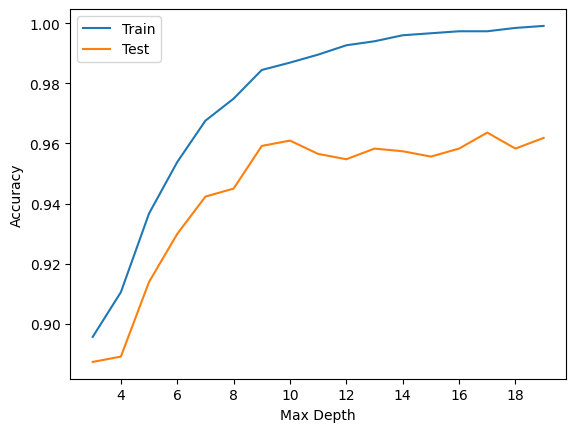

In [110]:
sns.lineplot(data=data1, x='Max_depth', y = 'TrainScore', label='Train')
sns.lineplot(data=data1, x='Max_depth', y = 'TestScore', label='Test')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

Confusion Matrix of Logistic Regression:
[[304  13   5   6]
 [ 12 215   0   0]
 [  0   0 273  11]
 [  4   0  46 238]]


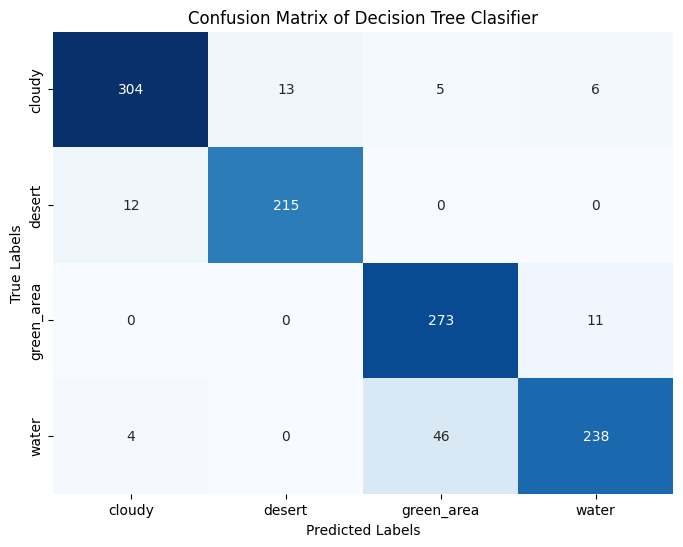

In [111]:
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf.fit(trainX, trainY)
predictions = treeclf.predict(testX)
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Decision Tree Clasifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [115]:
print(f'Accuracy: {accuracy_score(testY, predictions):.2f}, '
      f'Recall: {recall_score(testY, predictions, average="weighted"):.2f}, '
      f'Precision: {precision_score(testY, predictions, average="weighted"):.2f}, '
      f'F1 Score: {f1_score(testY, predictions, average="weighted"):.2f}')

Accuracy: 0.91, Recall: 0.91, Precision: 0.92, F1 Score: 0.91


In [117]:
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

In [176]:
import tensorflow as tf
trainY_one_hot = tf.keras.utils.to_categorical(trainY, num_classes=4)
testY_one_hot = tf.keras.utils.to_categorical(testY, num_classes=4)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, input_dim=6, activation='relu', name='Hiddenlayer1'),
    tf.keras.layers.Dense(5, activation='relu', name='HiddenLayer2'),  # First hidden layer with 6 neurons
    tf.keras.layers.Dense(4, activation='relu', name='HiddenLayer3'),  # Second hidden layer with 5 neurons
    tf.keras.layers.Dense(4, activation='softmax', name='OutputLayer')  # Output layer with 4 neurons (for classification)
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Metric to monitor
                                                   patience=5,          # Number of epochs with no improvement before stopping
                                                   restore_best_weights=True)  # Restore the best model weights
history = model.fit(trainX, trainY_one_hot, epochs=50, validation_data=(testX, testY_one_hot),
                    verbose=1, callbacks=[early_stopping])

Epoch 1/50
141/141 [==============================] - 6s 12ms/step - loss: 1.2547 - accuracy: 0.4179 - val_loss: 1.1187 - val_accuracy: 0.4641
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 1.0500 - accuracy: 0.4940 - val_loss: 0.9674 - val_accuracy: 0.5883
Epoch 3/50
141/141 [==============================] - 1s 9ms/step - loss: 0.9370 - accuracy: 0.5928 - val_loss: 0.8547 - val_accuracy: 0.6593
Epoch 4/50
141/141 [==============================] - 1s 10ms/step - loss: 0.8177 - accuracy: 0.6596 - val_loss: 0.7505 - val_accuracy: 0.7036
Epoch 5/50
141/141 [==============================] - 1s 8ms/step - loss: 0.7335 - accuracy: 0.7009 - val_loss: 0.6836 - val_accuracy: 0.7320
Epoch 6/50
141/141 [==============================] - 1s 6ms/step - loss: 0.6746 - accuracy: 0.7325 - val_loss: 0.6336 - val_accuracy: 0.7471
Epoch 7/50
141/141 [==============================] - 1s 8ms/step - loss: 0.6312 - accuracy: 0.7462 - val_loss: 0.5992 - val_accuracy: 0.7613
Epoc

In [177]:
predictions = model.predict(testX)
predicted_labels = np.argmax(predictions, axis=1)

36/36 [==============================] - 1s 8ms/step


In [178]:
trainscore={}
testscore={}

In [179]:
trainscore['6 ,5, 4']=model.evaluate(trainX, trainY_one_hot, verbose=0)[1]
testscore['6 ,5, 4'] = model.evaluate(testX, testY_one_hot, verbose=0)[1]

Confusion Matrix of Neural Network:
[[304  16   2   6]
 [  7 220   0   0]
 [  0   0 267  17]
 [  1   0  52 235]]


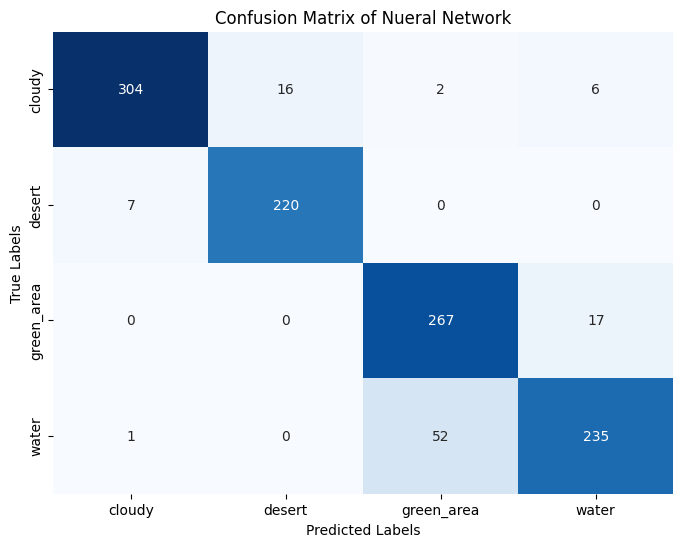

In [180]:
conf_matrix = confusion_matrix(testY, predicted_labels)
print("Confusion Matrix of Neural Network:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Nueral Network")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [182]:
dot = graphviz.Digraph(format='png')
input_nodes = ['meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB']

# Hidden layers (6, 5, and 4 neurons)
hidden_nodes1 = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']
hidden_nodes2 = ['H7', 'H8', 'H9', 'H10', 'H11']
hidden_nodes3 = ['H12', 'H13', 'H14', 'H15']

# Output layer (4 neurons)
output_nodes = ['Cloudy', 'Desert', 'Green Area', 'Water']
weights_input_hidden = model.layers[0].get_weights()[0]  # Weights between input and hidden layer 1
weights_hidden_1_2 = model.layers[1].get_weights()[0]  # Weights between hidden layer 1 and 2
weights_hidden_2_3 = model.layers[2].get_weights()[0]  # Weights between hidden layer 2 and 3
weights_hidden_3_output = model.layers[3].get_weights()[0] 
# Add nodes for input, hidden, and output layers
for node in input_nodes:
    dot.node(node, node)

for node in hidden_nodes1:
    dot.node(node, node)

for node in hidden_nodes2:
    dot.node(node, node)

for node in hidden_nodes3:
    dot.node(node, node)

for node in output_nodes:
    dot.node(node, node)

# Add edges with weight magnitudes and colors between layers
def add_weighted_edges(input_nodes, next_nodes, weights):
    for i, input_node in enumerate(input_nodes):
        for j, next_node in enumerate(next_nodes):
            weight = weights[i][j]
            edge_color = 'red' if weight < 0 else 'blue'  # Red for negative, green for positive weights
            edge_thickness = abs(weight)*2  # Magnitude determines thickness
            dot.edge(input_node, next_node, color=edge_color, penwidth=str(edge_thickness))

# Add edges between input layer and hidden layer 1
add_weighted_edges(input_nodes, hidden_nodes1, weights_input_hidden)

# Add edges between hidden layer 1 and hidden layer 2
add_weighted_edges(hidden_nodes1, hidden_nodes2, weights_hidden_1_2)

# Add edges between hidden layer 2 and hidden layer 3
add_weighted_edges(hidden_nodes2, hidden_nodes3, weights_hidden_2_3)

# Add edges between hidden layer 3 and output layer
add_weighted_edges(hidden_nodes3, output_nodes, weights_hidden_3_output)

# Render the graph
dot.render('neural_network_with_weights1', view=True)

'neural_network_with_weights1.png'

In [193]:
model = tf.keras.Sequential([
     # Input layer with 6 features
    tf.keras.layers.Dense(4,input_dim=6, activation='relu', name='Hiddenlayer1'),
    tf.keras.layers.Dense(3, activation='relu', name='HiddenLayer2'),  
    tf.keras.layers.Dense(2, activation='relu', name='HiddenLayer3'),
    tf.keras.layers.Dense(3, activation='relu', name='HiddenLayer4'),
    tf.keras.layers.Dense(4, activation='softmax', name='OutputLayer')  # Output layer with 4 neurons (for classification)
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Metric to monitor
                                                   patience=5,          # Number of epochs with no improvement before stopping
                                                   restore_best_weights=True)  # Restore the best model weights
history = model.fit(trainX, trainY_one_hot, epochs=50, validation_data=(testX, testY_one_hot),
                    verbose=1, callbacks=[early_stopping])
predictions = model.predict(testX)
predicted_labels = np.argmax(predictions, axis=1)
trainscore['4 ,3, 2, 3']=model.evaluate(trainX, trainY_one_hot, verbose=0)[1]
testscore['4 ,3, 2, 3'] = model.evaluate(testX, testY_one_hot, verbose=0)[1]

Epoch 1/50
141/141 [==============================] - 6s 13ms/step - loss: 1.3181 - accuracy: 0.4270 - val_loss: 1.2025 - val_accuracy: 0.5421
Epoch 2/50
141/141 [==============================] - 1s 7ms/step - loss: 1.1038 - accuracy: 0.5442 - val_loss: 1.0125 - val_accuracy: 0.5626
Epoch 3/50
141/141 [==============================] - 1s 7ms/step - loss: 0.9919 - accuracy: 0.5591 - val_loss: 0.9456 - val_accuracy: 0.5750
Epoch 4/50
141/141 [==============================] - 1s 9ms/step - loss: 0.9357 - accuracy: 0.5682 - val_loss: 0.9035 - val_accuracy: 0.5768
Epoch 5/50
141/141 [==============================] - 1s 7ms/step - loss: 0.8959 - accuracy: 0.5753 - val_loss: 0.8719 - val_accuracy: 0.5776
Epoch 6/50
141/141 [==============================] - 1s 7ms/step - loss: 0.8664 - accuracy: 0.5821 - val_loss: 0.8463 - val_accuracy: 0.5865
Epoch 7/50
141/141 [==============================] - 1s 9ms/step - loss: 0.8412 - accuracy: 0.5897 - val_loss: 0.8257 - val_accuracy: 0.5918
Epoch

In [175]:
dot = graphviz.Digraph(format='png')
input_nodes = ['meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB']  # 6 input features
hidden_nodes1 = ['H1', 'H2', 'H3', 'H4']  # 4 nodes for Hidden Layer 1
hidden_nodes2 = ['H5', 'H6', 'H7']  # 3 nodes for Hidden Layer 2
hidden_nodes3 = ['H8', 'H9']  # 2 nodes for Hidden Layer 3
hidden_nodes4 = ['H10', 'H11', 'H12']  # 3 nodes for Hidden Layer 4
output_nodes = ['Cloudy', 'Desert', 'Green Area', 'Water']  # Output layer with 4 neurons

# Weight matrices
weights_input_hidden = model.layers[0].get_weights()[0]   # Shape (6, 4)
weights_hidden_1_2 = model.layers[1].get_weights()[0]     # Shape (4, 3)
weights_hidden_2_3 = model.layers[2].get_weights()[0]     # Shape (3, 2)
weights_hidden_3_4 = model.layers[3].get_weights()[0]     # Shape (2, 3)
weights_hidden_4_output = model.layers[4].get_weights()[0] # Shape (3, 4)

# Add nodes for input, hidden, and output layers
for node in input_nodes:
    dot.node(node, node)

for node in hidden_nodes1:
    dot.node(node, node)

for node in hidden_nodes2:
    dot.node(node, node)

for node in hidden_nodes3:
    dot.node(node, node)

for node in hidden_nodes4:
    dot.node(node, node)

for node in output_nodes:
    dot.node(node, node)

# Define function to add weighted edges with color and thickness based on weight values
def add_weighted_edges(input_nodes, next_nodes, weights):
    for i, input_node in enumerate(input_nodes):
        for j, next_node in enumerate(next_nodes):
            weight = weights[i][j]
            edge_color = 'red' if weight < 0 else 'blue'  # Red for negative, blue for positive weights
            edge_thickness = abs(weight) *1  # Adjust thickness based on weight magnitude
            dot.edge(input_node, next_node, color=edge_color, penwidth=str(edge_thickness))

# Add edges between layers based on the weight matrices
add_weighted_edges(input_nodes, hidden_nodes1, weights_input_hidden)
add_weighted_edges(hidden_nodes1, hidden_nodes2, weights_hidden_1_2)
add_weighted_edges(hidden_nodes2, hidden_nodes3, weights_hidden_2_3)
add_weighted_edges(hidden_nodes3, hidden_nodes4, weights_hidden_3_4)
add_weighted_edges(hidden_nodes4, output_nodes, weights_hidden_4_output)

# Render the graph
dot.render('neural_network_with_weights2', view=True)


'neural_network_with_weights2.png'

In [183]:
model = tf.keras.Sequential([
     # Input layer with 6 features
    tf.keras.layers.Dense(10,input_dim=6, activation='relu', name='Hiddenlayer1'),
    tf.keras.layers.Dense(15, activation='relu', name='HiddenLayer2'),  
    tf.keras.layers.Dense(5, activation='relu', name='HiddenLayer3'),
    tf.keras.layers.Dense(8, activation='relu', name='HiddenLayer4'),
    tf.keras.layers.Dense(4, activation='softmax', name='OutputLayer')  # Output layer with 4 neurons (for classification)
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Metric to monitor
                                                   patience=5,          # Number of epochs with no improvement before stopping
                                                   restore_best_weights=True)  # Restore the best model weights
history = model.fit(trainX, trainY_one_hot, epochs=50, validation_data=(testX, testY_one_hot),
                    verbose=1, callbacks=[early_stopping])
predictions = model.predict(testX)
predicted_labels = np.argmax(predictions, axis=1)
trainscore['10, 15, 5, 8']=model.evaluate(trainX, trainY_one_hot, verbose=0)[1]
testscore['10, 15, 5, 8'] = model.evaluate(testX, testY_one_hot, verbose=0)[1]

Epoch 1/50
141/141 [==============================] - 6s 13ms/step - loss: 1.2392 - accuracy: 0.4460 - val_loss: 1.0163 - val_accuracy: 0.5271
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 0.8355 - accuracy: 0.5528 - val_loss: 0.7487 - val_accuracy: 0.5688
Epoch 3/50
141/141 [==============================] - 1s 10ms/step - loss: 0.7192 - accuracy: 0.5675 - val_loss: 0.6910 - val_accuracy: 0.5617
Epoch 4/50
141/141 [==============================] - 1s 7ms/step - loss: 0.6360 - accuracy: 0.6852 - val_loss: 0.5326 - val_accuracy: 0.8332
Epoch 5/50
141/141 [==============================] - 1s 9ms/step - loss: 0.4424 - accuracy: 0.8464 - val_loss: 0.3792 - val_accuracy: 0.8855
Epoch 6/50
141/141 [==============================] - 1s 9ms/step - loss: 0.3477 - accuracy: 0.8786 - val_loss: 0.3337 - val_accuracy: 0.8891
Epoch 7/50
141/141 [==============================] - 1s 7ms/step - loss: 0.3092 - accuracy: 0.8899 - val_loss: 0.3120 - val_accuracy: 0.8944
Epoc

In [199]:
score=pd.DataFrame(list(testscore.values()), index=testscore.keys(), columns = ['TestScore'])

In [200]:
score['TrainScore'] = list(trainscore.values())

In [201]:
score = score.reset_index()
score.columns = ['HiddenLayers', 'TestScore', 'TrainScore']

In [202]:
score

,HiddenLayers,TestScore,TrainScore
0,"6 ,5, 4",0.910382,0.927398
1,"10, 15, 5, 8",0.944987,0.946936
2,"4 ,3, 2, 3",0.691216,0.700488


In [155]:
print("weights_input_hidden shape:", weights_input_hidden.shape)
print("weights_hidden_1_2 shape:", weights_hidden_1_2.shape)
print("weights_hidden_2_3 shape:", weights_hidden_2_3.shape)
print("weights_hidden_3_4 shape:", weights_hidden_3_4.shape)
print("weights_hidden_4_output shape:", weights_hidden_4_output.shape)

weights_input_hidden shape: (6, 6)
weights_hidden_1_2 shape: (6, 4)
weights_hidden_2_3 shape: (4, 3)
weights_hidden_3_4 shape: (3, 2)
weights_hidden_4_output shape: (2, 3)


In [162]:
print(f"hidden_nodes3: {len(hidden_nodes3)} nodes, weights_hidden_3_4 shape: {weights_hidden_3_4.shape}")
print(f"hidden_nodes4: {len(hidden_nodes4)} nodes")

hidden_nodes3: 2 nodes, weights_hidden_3_4 shape: (3, 2)
hidden_nodes4: 3 nodes


In [163]:
input_nodes = ['meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB']
hidden_nodes1 = ['H1', 'H2', 'H3', 'H4']
hidden_nodes2 = ['H5', 'H6', 'H7']
hidden_nodes3 = ['H8', 'H9']
hidden_nodes4 = ['H10', 'H11', 'H12']
output_nodes = ['Cloudy', 'Desert', 'Green Area', 'Water']

# Add nodes to the graph
for node in input_nodes + hidden_nodes1 + hidden_nodes2 + hidden_nodes3 + hidden_nodes4 + output_nodes:
    dot.node(node, node)

# Add weighted edges function
def add_weighted_edges(input_nodes, next_nodes, weights):
    for i, input_node in enumerate(input_nodes):
        for j, next_node in enumerate(next_nodes):
            weight = weights[i][j]
            edge_color = 'red' if weight < 0 else 'blue'
            edge_thickness = abs(weight) ** 2  # Adjust thickness based on weight magnitude
            dot.edge(input_node, next_node, color=edge_color, penwidth=str(edge_thickness))

# Add edges between layers with weights
add_weighted_edges(input_nodes, hidden_nodes1, weights_input_hidden)
add_weighted_edges(hidden_nodes1, hidden_nodes2, weights_hidden_1_2)
add_weighted_edges(hidden_nodes2, hidden_nodes3, weights_hidden_2_3)
add_weighted_edges(hidden_nodes3, hidden_nodes4, weights_hidden_3_4)
add_weighted_edges(hidden_nodes4, output_nodes, weights_hidden_4_output)

# Render the graph
dot.render('neural_network_with_weights', view=True)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [170]:
 model.layers[0].get_weights()[0]

array([[-0.6219044 , -0.26944476,  1.5961229 ,  1.0076734 , -1.4780985 ,
        -0.88814557],
       [ 0.18202813,  1.345811  ,  0.23080558,  0.59979403,  0.08889824,
         0.03357269],
       [ 0.30096674,  0.01529623, -0.30095118, -0.73036456,  1.4901589 ,
         0.7050327 ],
       [-0.7420987 ,  0.76396286,  0.30684686, -0.4349651 , -0.25199413,
         0.5712526 ],
       [-0.6855034 ,  0.62862545, -0.30059135,  0.2873907 ,  0.12710246,
         0.6716149 ],
       [-0.04634815,  1.0756493 , -0.30618426,  0.8818514 ,  0.3208617 ,
        -0.8686986 ]], dtype=float32)

In [165]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Dense)          (None, 6)                 42        
                                                                 
 Hiddenlayer1 (Dense)        (None, 4)                 28        
                                                                 
 HiddenLayer2 (Dense)        (None, 3)                 15        
                                                                 
 HiddenLayer3 (Dense)        (None, 2)                 8         
                                                                 
 HiddenLayer4 (Dense)        (None, 3)                 9         
                                                                 
 OutputLayer (Dense)         (None, 4)                 16        
                                                                 
Total params: 118 (472.00 Byte)
Trainable params: 118 